**Importing modules**

In [68]:
import os 
import numpy as np
import pandas as pd 
import tensorflow as tf
import string 
import gc 
from sklearn.model_selection import train_test_split

# Tensorflow modules
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer


**Creating a function to clean all the data**

In [69]:
def clean_data(text):
    text=str(text)
    text=''.join([i for i in text if i not in string.punctuation]) 
    text=text.encode('utf-8').decode('ascii','ignore')
    return text

**Building the custom sequence generator class**

In [70]:
class Data_generator(Sequence):
    def __init__(self,texts,labels,tokenizer,max_sequence_len,batch_size=512):
        self.texts=texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_sequence_len = max_sequence_len
        self.batch_size = batch_size
        self.indices = np.arange(len(self.texts)) 

    def __len__(self):
        return int(np.ceil(len(self.texts)/self.batch_size)) 

    def __getitem__(self,idx):
        batch_indices=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_texts=[self.texts[i] for i in batch_indices]
        batch_labels=[self.labels[i] for i in batch_indices] 

        sequences=self.tokenizer.texts_to_sequences(batch_texts)
        padded=pad_sequences(sequences,maxlen=self.max_sequence_len,padding='post',truncating='post')

        return np.array(padded),np.array(batch_labels) 

**Loading the dataset**

In [71]:
data=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

# Cleaning the data
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0}) #encoding positive and negative to make it easier in training
data['review']=data['review'].apply(clean_data)


**Splitting into training and testing data**

In [72]:
train_val_data,test_data=train_test_split(data,test_size=5000,random_state=42,stratify=data['sentiment'])
train_data,val_data=train_test_split(train_val_data,test_size=5000,random_state=42,stratify=train_val_data['sentiment'])

**Fitting the tokenzier**

In [73]:
max_words=20000
max_len=200

tokenizer=Tokenizer(num_words=max_words,oov_token="<OOV>")
tokenizer.fit_on_texts(train_val_data['review'])

**Building the simple rnn model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,Dense,Dropout

model_test=Sequential()
model_test.add(Embedding(max_words,128,input_length=max_len))
model_test.add(SimpleRNN(128,return_sequences=True))
model_test.add(Dropout(0.3))
model_test.add(SimpleRNN(64,return_sequences=False))
model_test.add(Dropout(0.4))
model_test.add(Dense(1,activation='sigmoid'))

model_test.build(input_shape=(None, max_len))
model_test.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_test.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 200, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,605,313 (9.94 MB)

 Trainable params: 2,605,313 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

**Using the data generators**

In [75]:
train_gen = Data_generator(
    train_data['review'].tolist(),
    train_data['sentiment'].tolist(),
    tokenizer,
    max_len,
    batch_size=512
)

test_gen = Data_generator(
    test_data['review'].tolist(),
    test_data['sentiment'].tolist(),
    tokenizer,
    max_len,
    batch_size=512
) 

val_gen= Data_generator(
    val_data['review'].tolist(),
    val_data['sentiment'].tolist(),
    tokenizer,
    max_len,
    batch_size=512
)


**Creating callbacks**

In [76]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint=ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      
    patience=3,      
    min_lr=1e-6,     
    verbose=1
)
callbacks=[early_stopping,checkpoint,reduce_lr]

**Training the model**

In [77]:
hist=model_test.fit(train_gen,validation_data=val_gen,epochs=30,callbacks=callbacks,verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5041 - loss: 0.7274
Epoch 1: val_loss improved from inf to 0.69521, saving model to best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.5040 - loss: 0.7274 - val_accuracy: 0.5026 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 2/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5275 - loss: 0.6943
Epoch 2: val_loss did not improve from 0.69521
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5276 - loss: 0.6943 - val_accuracy: 0.5020 - val_loss: 0.7024 - learning_rate: 0.0010
Epoch 3/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6130 - loss: 0.6400
Epoch 3: val_loss did not improve from 0.69521
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6130 - loss: 0.6399 - val_accuracy: 0.4966 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7224 - loss: 0.4817
Epoch 4: val_loss did not improve from 0.69521

Epoch 4: ReduceL

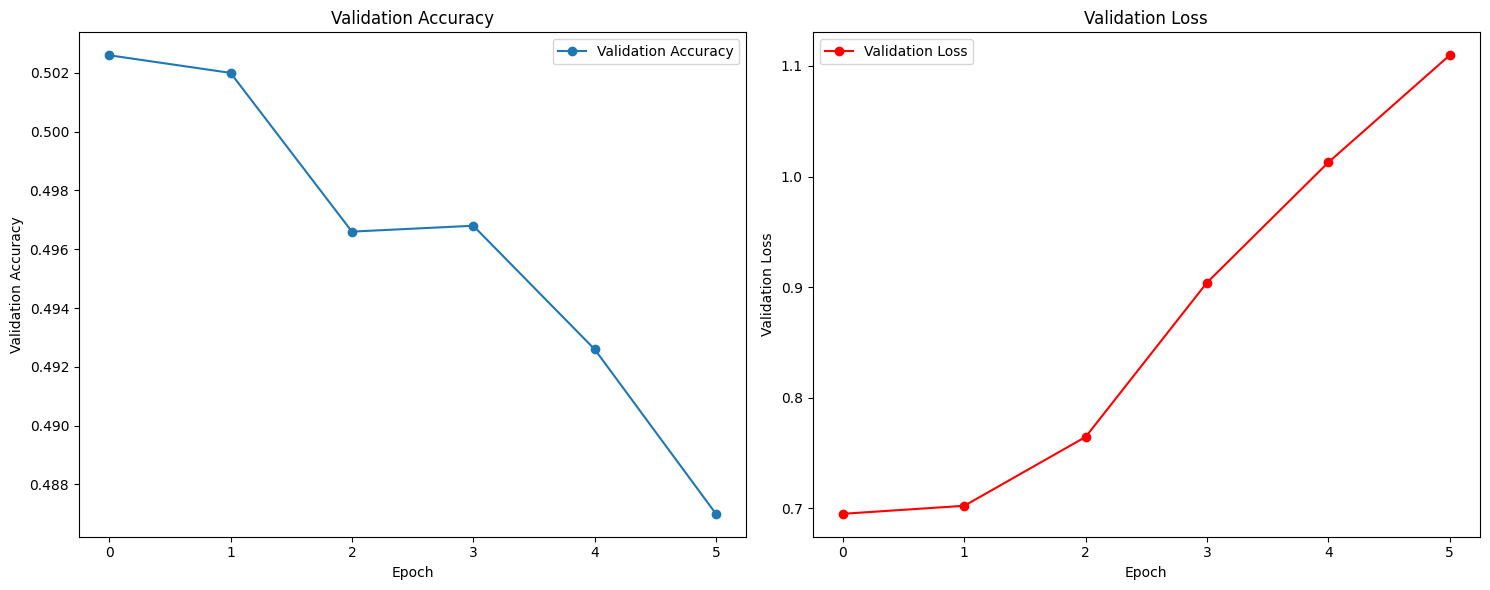

In [78]:
import matplotlib.pyplot as plt

history = hist.history

# Create subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Validation Accuracy
ax1.plot(history["val_accuracy"], label="Validation Accuracy", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Accuracy")
ax1.set_title("Validation Accuracy")
ax1.legend()

# Validation Loss
ax2.plot(history["val_loss"], label="Validation Loss", marker="o", color="red")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Loss")
ax2.set_title("Validation Loss")
ax2.legend()

plt.tight_layout()
plt.show()
